In [8]:
import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt

In [9]:
# Transform MMFi-style action segment CSV into a long format with Start/End per segment.
# - Reads the attached CSV at /mnt/data/MMFi_action_segments.csv
# - Expands variable number of "val1-val2" segment columns into rows
# - Writes the result to /mnt/data/MMFi_action_segments_long.csv
#
# You can reuse the function `expand_segments_df` for your own CSVs in your notebook.



INPUT_PATH = Path("C:\\Users\\thako\\OneDrive\\Desktop\\mmwave Try2\\MMFi_action_segments.csv")
OUTPUT_PATH = Path("C:\\Users\\thako\\OneDrive\\Desktop\\mmwave Try2\\MMFi_action_segments_long.csv")

def expand_segments_df(df: pd.DataFrame,
                       id_cols=("Environment","Subject","Action")) -> pd.DataFrame:
    """
    Expand a wide CSV where the first three columns are Environment, Subject, Action,
    and the remaining columns contain 'start-end' strings for variable numbers of segments.
    
    Returns a long DataFrame with columns: Environment, Subject, Action, Start, End.
    """
    # If the file's first three columns aren't exactly named, rename them positionally.
    expected = list(id_cols)
    if list(df.columns[:3]) != expected:
        rename_map = {df.columns[0]: expected[0],
                      df.columns[1]: expected[1],
                      df.columns[2]: expected[2]}
        df = df.rename(columns=rename_map)
    
    id_df = df[list(id_cols)]
    seg_df = df.drop(columns=list(id_cols))
    
    # Melt/stack all segment columns into a single Series
    stacked = (
        pd.concat([id_df, seg_df], axis=1)
        .melt(id_vars=list(id_cols), var_name="SegmentCol", value_name="Range")
    )
    
    # Clean and drop empty/NaN ranges
    stacked["Range"] = stacked["Range"].astype(str).str.strip()
    # Treat empty strings, "nan", "NaN" etc. as missing
    stacked = stacked.replace({"Range": {"nan": None, "NaN": None, "None": None, "": None}})
    stacked = stacked.dropna(subset=["Range"])
    
    # Keep only values that look like start-end (allow spaces)
    # e.g., "1-7", " 1 - 7 ", supports negative/decimal if ever needed
    pattern = re.compile(r"^\s*(-?\d+(?:\.\d+)?)\s*-\s*(-?\d+(?:\.\d+)?)\s*$")
    def parse_range(s):
        m = pattern.match(str(s))
        if not m:
            return None, None
        return m.group(1), m.group(2)
    
    parsed = stacked["Range"].apply(parse_range)
    stacked["Start"] = parsed.apply(lambda t: t[0])
    stacked["End"]   = parsed.apply(lambda t: t[1])
    
    # Drop rows that didn't match the range pattern (e.g., stray text)
    stacked = stacked.dropna(subset=["Start","End"])
    
    # Convert to numeric if possible
    stacked["Start"] = pd.to_numeric(stacked["Start"], errors="coerce")
    stacked["End"]   = pd.to_numeric(stacked["End"], errors="coerce")
    stacked = stacked.dropna(subset=["Start","End"])
    
    # Select and sort
    out = stacked[list(id_cols) + ["Start","End"]].sort_values(list(id_cols) + ["Start","End"]).reset_index(drop=True)
    return out

# Load input CSV (robust read: handle potential extra commas)
df = pd.read_csv(INPUT_PATH, dtype=str, keep_default_na=True)
long_df = expand_segments_df(df)

# Save and show
long_df.to_csv(OUTPUT_PATH, index=False)

# Display a preview table for the user
from ace_tools_open import display_dataframe_to_user
display_dataframe_to_user("Expanded MMFi Segments (preview)", long_df.head(100))

OUTPUT_PATH.as_posix()

Expanded MMFi Segments (preview)


Loading ITables v2.5.2 from the internet... (need help?)


'C:/Users/thako/OneDrive/Desktop/mmwave Try2/MMFi_action_segments_long.csv'

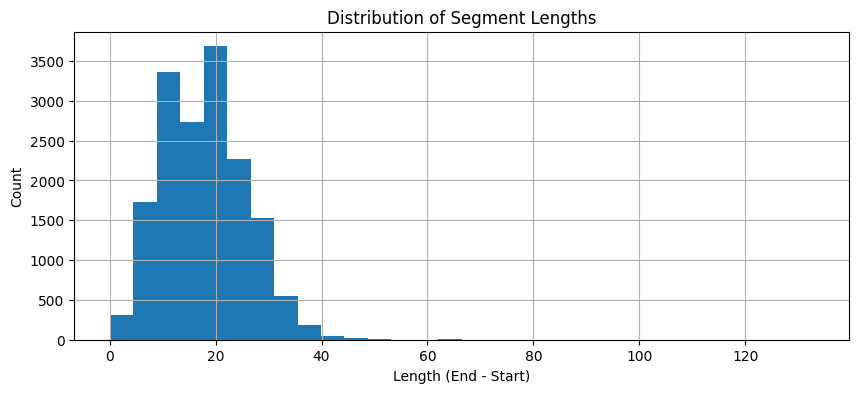

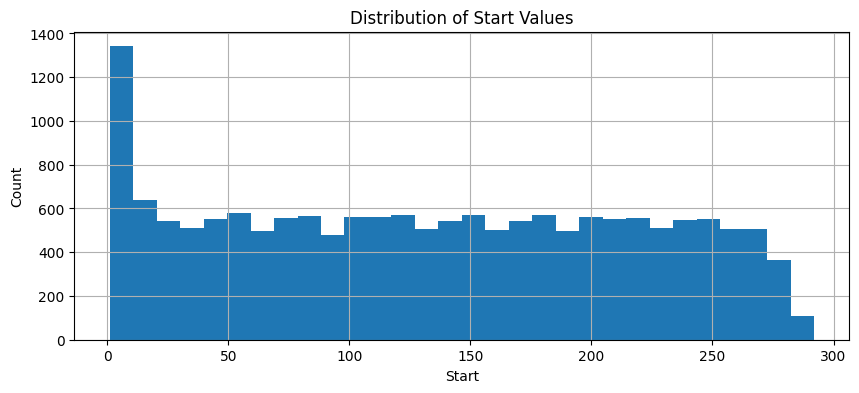

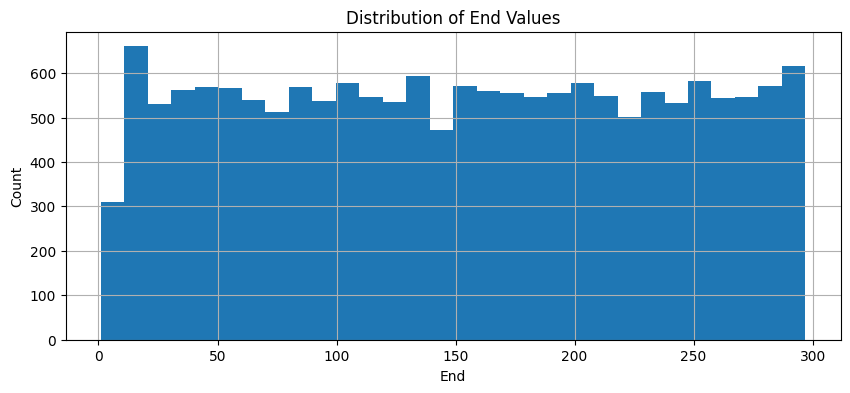

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
A01,1547.0,6.577893,2.663218,0.0,5.0,6.0,8.00,22.0
A02,357.0,30.899160,8.252744,0.0,26.0,31.0,35.00,133.0
A03,363.0,30.055096,7.856253,1.0,26.0,29.0,34.00,66.0
A04,598.0,18.230769,5.762490,0.0,14.0,18.0,21.00,45.0
A05,614.0,17.755700,5.254277,4.0,14.0,17.0,21.00,35.0
A06,984.0,10.843496,2.093904,0.0,10.0,11.0,12.00,28.0
A07,439.0,25.134396,6.671871,6.0,19.0,25.0,30.00,46.0
A08,458.0,24.032751,6.826148,0.0,18.0,24.0,29.75,54.0
A09,580.0,18.710345,5.265874,0.0,14.0,18.0,23.00,38.0


In [10]:
# Load your expanded CSV
df = pd.read_csv("C:\\Users\\thako\\OneDrive\\Desktop\\mmwave Try2\\MMFi_action_segments_long.csv")

# Compute segment length
df["Length"] = df["End"] - df["Start"]

# -------------------------------
# 1) Distribution of segment lengths
# -------------------------------
plt.figure(figsize=(10,4))
df["Length"].hist(bins=30)
plt.title("Distribution of Segment Lengths")
plt.xlabel("Length (End - Start)")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 2) Distribution of Start values
# -------------------------------
plt.figure(figsize=(10,4))
df["Start"].hist(bins=30)
plt.title("Distribution of Start Values")
plt.xlabel("Start")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 3) Distribution of End values
# -------------------------------
plt.figure(figsize=(10,4))
df["End"].hist(bins=30)
plt.title("Distribution of End Values")
plt.xlabel("End")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 4) Optional: per-action distribution summary
# -------------------------------
summary = df.groupby("Action")["Length"].describe()
summary

# Dropping A01 A02 A03 A06 A26 below

In [29]:
import pandas as pd

# Load the expanded CSV
df = pd.read_csv("C:\\Users\\thako\\OneDrive\\Desktop\\mmwave Try2\\MMFi_action_segments_long.csv")

# Actions to remove
remove_actions = ["A01", "A02", "A03", "A06"]

# Drop rows where Action is in the list
df_filtered = df[~df["Action"].isin(remove_actions)].reset_index(drop=True)

# Save if needed
df_filtered.to_csv("C:\\Users\\thako\\OneDrive\\Desktop\\mmwave Try2\\MMFi_action_segments_long_rm_A1_2_3_6.csv", index=False)

df_filtered.head()


,Environment,Subject,Action,Start,End
0,E01,S01,A04,1,11
1,E01,S01,A04,12,26
2,E01,S01,A04,27,42
3,E01,S01,A04,43,56
4,E01,S01,A04,57,72


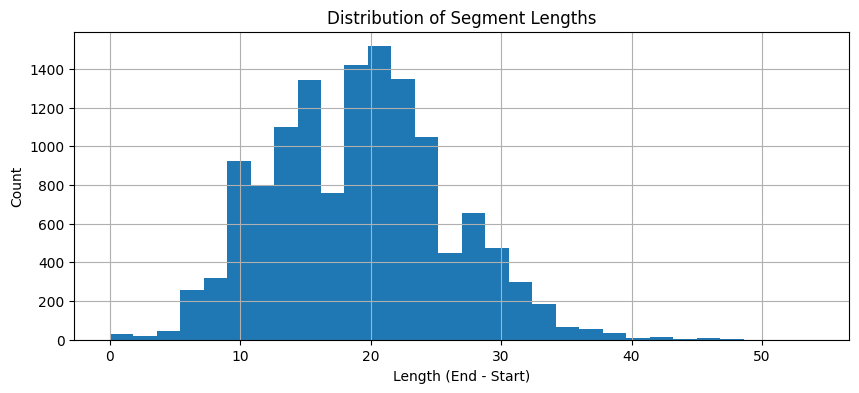

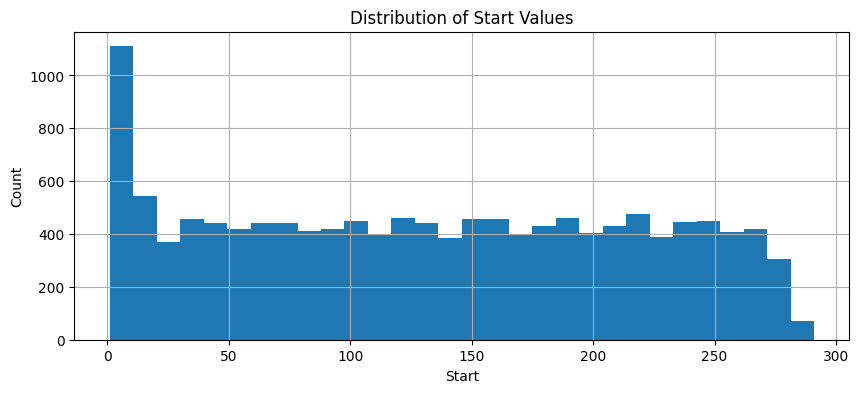

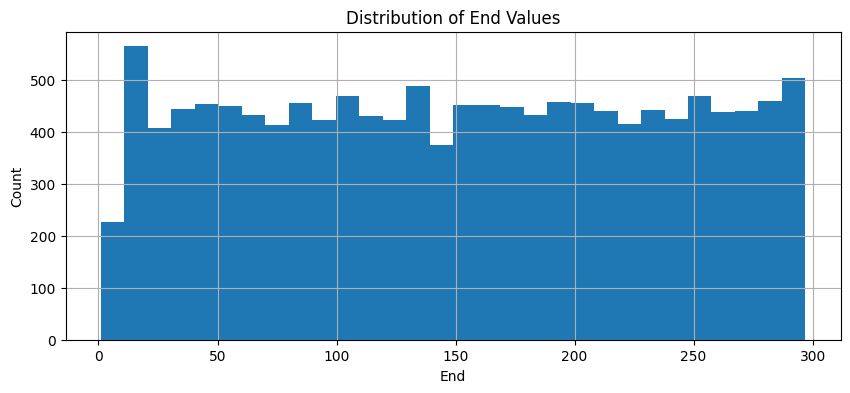

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
A04,598.0,18.230769,5.762490,0.0,14.0,18.0,21.00,45.0
A05,614.0,17.755700,5.254277,4.0,14.0,17.0,21.00,35.0
A07,439.0,25.134396,6.671871,6.0,19.0,25.0,30.00,46.0
A08,458.0,24.032751,6.826148,0.0,18.0,24.0,29.75,54.0
A09,580.0,18.710345,5.265874,0.0,14.0,18.0,23.00,38.0
A10,575.0,18.987826,5.669915,0.0,15.0,18.0,23.00,42.0
A11,445.0,24.770787,6.805638,0.0,20.0,24.0,30.00,46.0
A12,556.0,19.710432,5.660417,0.0,16.0,19.0,23.00,49.0
A13,576.0,19.003472,4.687818,2.0,16.0,19.0,23.00,32.0


In [30]:
# Load your expanded CSV
df = pd.read_csv("C:\\Users\\thako\\OneDrive\\Desktop\\mmwave Try2\\MMFi_action_segments_long_rm_A1_2_3_6.csv")

# Compute segment length
df["Length"] = df["End"] - df["Start"]

# -------------------------------
# 1) Distribution of segment lengths
# -------------------------------
plt.figure(figsize=(10,4))
df["Length"].hist(bins=30)
plt.title("Distribution of Segment Lengths")
plt.xlabel("Length (End - Start)")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 2) Distribution of Start values
# -------------------------------
plt.figure(figsize=(10,4))
df["Start"].hist(bins=30)
plt.title("Distribution of Start Values")
plt.xlabel("Start")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 3) Distribution of End values
# -------------------------------
plt.figure(figsize=(10,4))
df["End"].hist(bins=30)
plt.title("Distribution of End Values")
plt.xlabel("End")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 4) Optional: per-action distribution summary
# -------------------------------
summary = df.groupby("Action")["Length"].describe()
summary

In [31]:

# Load filtered CSV (or your working dataframe)
df = pd.read_csv("C:\\Users\\thako\\OneDrive\\Desktop\\mmwave Try2\\MMFi_action_segments_long_rm_A1_2_3_6.csv")

# Compute length if not already present
df["Length"] = df["End"] - df["Start"]

# Keep only rows where 10 <= Length <= 30
df_len_filtered = df[(df["Length"] >= 10) & (df["Length"] <= 30)].reset_index(drop=True)

# Save if needed
df_len_filtered.to_csv("C:\\Users\\thako\\OneDrive\\Desktop\\mmwave Try2\\MMFi_action_segments_rmA1_2_3_6_len10to30.csv", index=False)

df_len_filtered.head()


,Environment,Subject,Action,Start,End,Length
0,E01,S01,A04,1,11,10
1,E01,S01,A04,12,26,14
2,E01,S01,A04,27,42,15
3,E01,S01,A04,43,56,13
4,E01,S01,A04,57,72,15


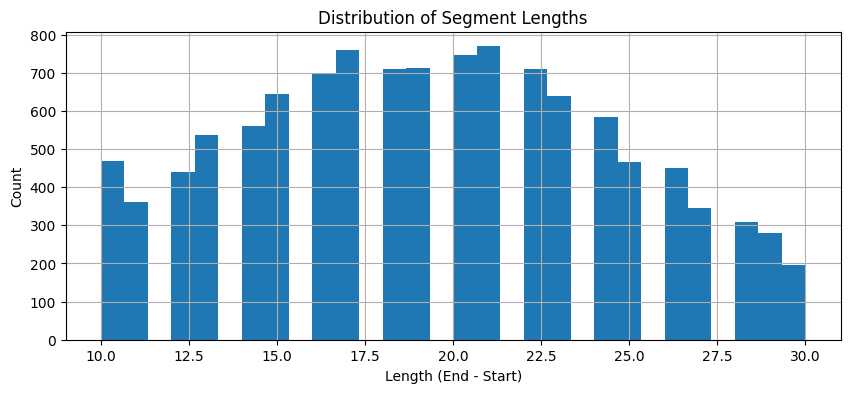

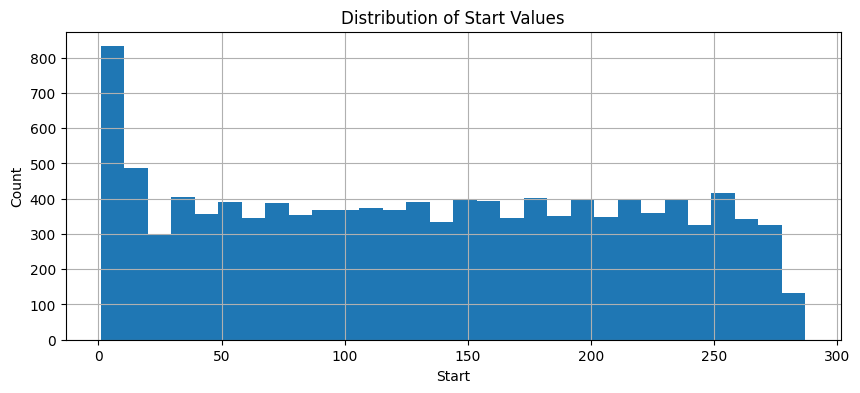

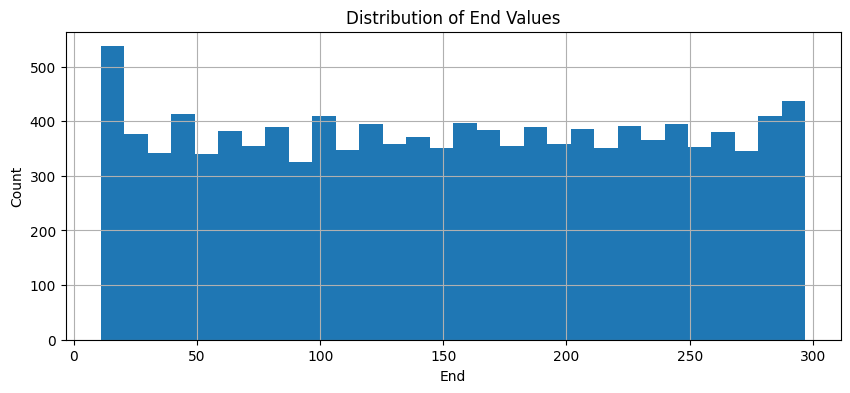

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
A04,562.0,18.030249,4.540663,10.0,15.00,18.0,21.00,30.0
A05,576.0,17.631944,4.316998,10.0,15.00,17.0,21.00,30.0
A07,344.0,22.898256,4.758739,10.0,18.75,24.0,27.00,30.0
A08,358.0,21.527933,4.851065,10.0,17.00,21.0,26.00,30.0
A09,563.0,18.737123,4.796776,10.0,15.00,18.0,22.00,30.0
A10,543.0,18.898711,4.596932,10.0,15.00,18.0,22.00,30.0
A11,343.0,22.332362,4.620103,11.0,18.00,22.0,26.00,30.0
A12,522.0,19.237548,4.588340,10.0,16.00,19.0,22.00,30.0
A13,561.0,19.245989,4.277861,10.0,16.00,19.0,23.00,30.0


In [32]:
# Load your expanded CSV
df = pd.read_csv("C:\\Users\\thako\\OneDrive\\Desktop\\mmwave Try2\\MMFi_action_segments_rmA1_2_3_6_len10to30.csv")

# Compute segment length
df["Length"] = df["End"] - df["Start"]

# -------------------------------
# 1) Distribution of segment lengths
# -------------------------------
plt.figure(figsize=(10,4))
df["Length"].hist(bins=30)
plt.title("Distribution of Segment Lengths")
plt.xlabel("Length (End - Start)")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 2) Distribution of Start values
# -------------------------------
plt.figure(figsize=(10,4))
df["Start"].hist(bins=30)
plt.title("Distribution of Start Values")
plt.xlabel("Start")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 3) Distribution of End values
# -------------------------------
plt.figure(figsize=(10,4))
df["End"].hist(bins=30)
plt.title("Distribution of End Values")
plt.xlabel("End")
plt.ylabel("Count")
plt.show()

# -------------------------------
# 4) Optional: per-action distribution summary
# -------------------------------
summary = df.groupby("Action")["Length"].describe()
summary

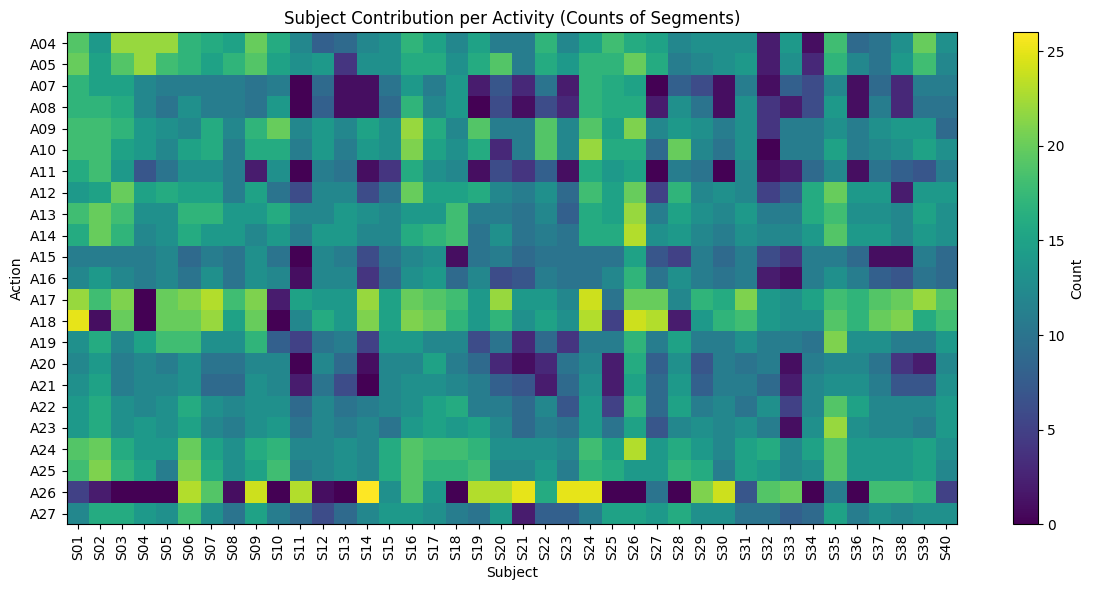

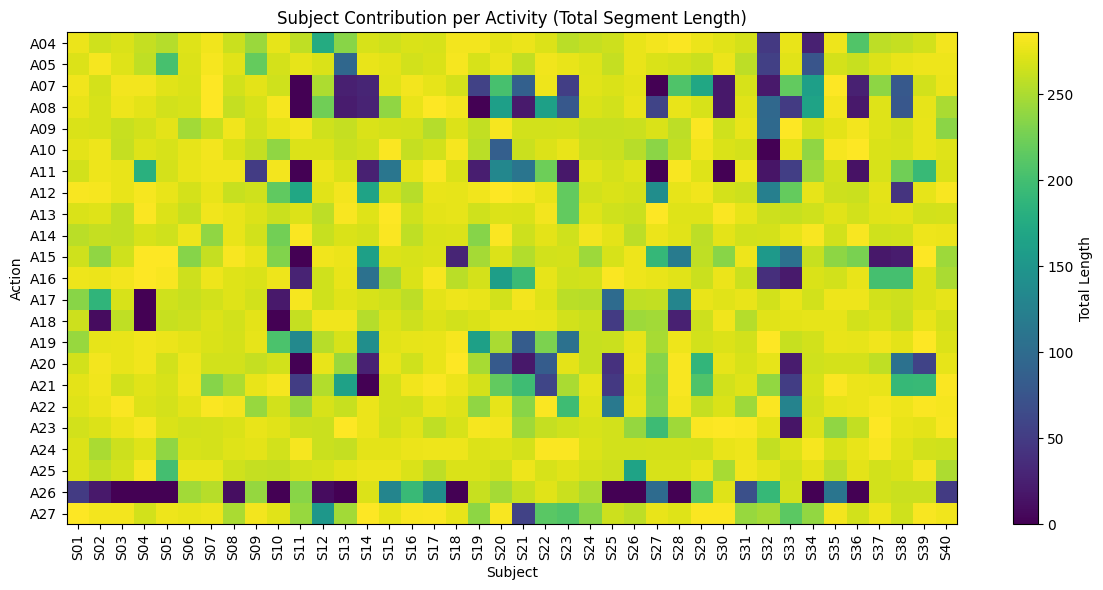

C:\Users\thako\AppData\Local\Temp\ipykernel_27044\3331817595.py:87: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

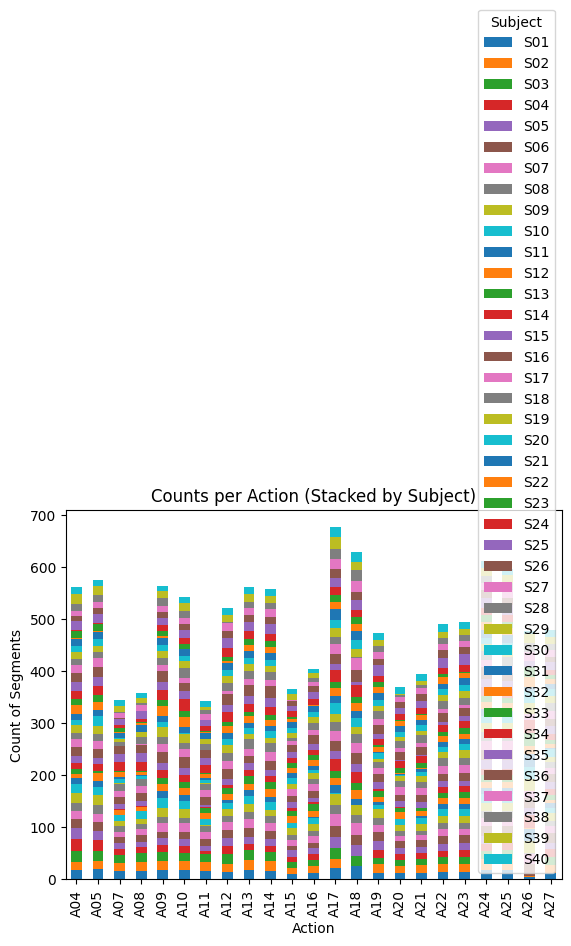

Top Contributors per Action


Loading ITables v2.5.2 from the internet... (need help?)


In [33]:
# Visualize each subject's contribution to each activity (Action).
# The script computes two notions of "contribution":
#   1) Number of segments per (Subject, Action)
#   2) Total segment length per (Subject, Action)
# It renders:
#   - Heatmap of segment COUNTS by Action x Subject
#   - Heatmap of TOTAL LENGTH by Action x Subject
#   - Stacked bar chart: counts per Action, stacked by Subject
#
# It expects the expanded (and optionally filtered) CSV with columns:
#   Environment, Subject, Action, Start, End
# If you've saved the earlier filtered file, this will try to read it first;
# otherwise it falls back to the long-format CSV.



# Try the most recent filtered CSV first; fall back to earlier ones
candidates = [
    Path("C:\\Users\\thako\\OneDrive\\Desktop\\mmwave Try2\\MMFi_action_segments_rmA1_2_3_6_len10to30.csv")
]

input_path = None
for p in candidates:
    if p.exists():
        input_path = p
        break

if input_path is None:
    raise FileNotFoundError("No input CSV found. Please run the previous steps to generate the long-format CSV.")

df = pd.read_csv(input_path)

# Ensure needed columns exist and compute Length
required_cols = {"Environment","Subject","Action","Start","End"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")
df["Length"] = df["End"] - df["Start"]

# Normalize types as strings for pivot clarity
df["Subject"] = df["Subject"].astype(str)
df["Action"] = df["Action"].astype(str)

# Build contribution matrices
counts = (
    df.pivot_table(index="Action", columns="Subject", values="Length", aggfunc="count", fill_value=0)
    .sort_index()
    .sort_index(axis=1)
)

totals = (
    df.pivot_table(index="Action", columns="Subject", values="Length", aggfunc="sum", fill_value=0)
    .sort_index()
    .sort_index(axis=1)
)

# --- Heatmap of segment COUNTS ---
plt.figure(figsize=(12, 6))
plt.imshow(counts.values, aspect="auto")
plt.title("Subject Contribution per Activity (Counts of Segments)")
plt.xlabel("Subject")
plt.ylabel("Action")
plt.xticks(range(len(counts.columns)), counts.columns, rotation=90)
plt.yticks(range(len(counts.index)), counts.index)
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()

# --- Heatmap of TOTAL LENGTHS ---
plt.figure(figsize=(12, 6))
plt.imshow(totals.values, aspect="auto")
plt.title("Subject Contribution per Activity (Total Segment Length)")
plt.xlabel("Subject")
plt.ylabel("Action")
plt.xticks(range(len(totals.columns)), totals.columns, rotation=90)
plt.yticks(range(len(totals.index)), totals.index)
plt.colorbar(label="Total Length")
plt.tight_layout()
plt.show()

# --- Stacked bar chart: counts per Action stacked by Subject ---
plt.figure(figsize=(12, 6))
counts.plot(kind="bar", stacked=True, legend=True)
plt.title("Counts per Action (Stacked by Subject)")
plt.xlabel("Action")
plt.ylabel("Count of Segments")
plt.tight_layout()
plt.show()

# Optional: show a quick summary table of top contributing subject per action (by count and by total length)
top_count = counts.idxmax(axis=1).to_frame(name="TopSubject_ByCount")
top_count["MaxCount"] = counts.max(axis=1)

top_total = totals.idxmax(axis=1).to_frame(name="TopSubject_ByTotalLength")
top_total["MaxTotalLength"] = totals.max(axis=1)

summary = top_count.join(top_total)
from ace_tools_open import display_dataframe_to_user
display_dataframe_to_user("Top Contributors per Action", summary.reset_index().rename(columns={"index":"Action"}))
